This first model is based of the paper: "Three-Dimensional Spatiotemporal Modeling of Colon Cancer Organoids Reveals that Multimodal Control of Stem Cell Self-Renewal is a Critical Determinant of Size and Shape in Early Stages of Tumor Growth"

The model is a 3D spatiotemporal model of a cancer organoid. It is a system of partial differential equations (PDEs) that describe the dynamics of the organoid.

The model is a system of 3 PDEs:

The reaction-diffusion equation in 1-dimension is given by:

$$\frac{\partial C_i}{\partial t} = D_i \frac{\partial^2 C_i}{\partial x^2} + R_i(C_1, C_2, C_3, D)$$


Where $C_i$ is the concentration of the i-th species, $D_i$ is the diffusion coefficient, and $R_i$ is the reaction term.
- $C_1(x,t)$ is the concentration of the stem cells
- $C_2(x,t)$ is the concentration of the proginator cells
- $C_3(x,t)$ is the concentration of the dead cells
- $D(x,t)$ is the the drug concentration


The reaction term is different for each species of cell (without any drug diffusion component), each is given by:

- $R_1(C_1, C_2, C_3, D) = \lambda_1 C_1 - \mu_1 C_1 - \gamma_1 C_1$

The $\lambda_1 C_1$ term is the self renewal rate of the stem cells, controlled by the parameter $\lambda_1$.

The $-\mu_1 C_1$ term is the rate of stem cell death, controlled by the parameter $\mu_1$.

The $-\gamma_1 C_1$ term is the rate of stem cell differentiation (into proginator cells), controlled by the parameter $\gamma_1$.



- $R_2(C_1, C_2, C_3, D) = \gamma_1 C_1 - \gamma_2 C_2 - \mu_2 C_2$

The $\gamma_1 C_1$ term is the rate of stem cell differentiation (into proginator cells, positive component from $R_1$), controlled by the parameter $\gamma_1$.

The $-\gamma_2 C_2$ term is the rate of proginator cell differentiation (into dead cells), controlled by the parameter $\gamma_2$.

The $-\mu_2 C_2$ term is the rate of proginator cell death, controlled by the parameter $\mu_2$.



- $R_3(C_1, C_2, C_3, D) = \gamma_2 C_2 - \mu_3 C_3$

The $\gamma_2 C_2$ term is the rate of proginator cell differentiation (into dead cells, positive component from $R_2$), controlled by the parameter $\gamma_2$.

The $-\mu_3 C_3$ term is the rate of natural decay of dead cells, controlled by the parameter $\mu_3$.



In [72]:
import numpy as np
import matplotlib.pyplot as plt

If we are to set up a simple implementation of this model, we can start by defining the parameters of the system, and the reaction terms.

In [102]:
# length of the 1D domain
L = 1

# number of grid points
N = 100

# grid spacing
dx = L / N

# total time
T = 20
# time step
dt = 0.01
# number of time steps
Nt = int(T / dt)

# diffusion coefficients
D1, D2, D3 = 0.001, 0.0005, 0.0001

# reaction rates R1
lambda1 = 0.2
mu1 = 0.1
gamma1 = 0.4

# reaction rates R2
gamma2 = 0.1
mu2 = 0.3

# reaction rates R3
mu3 = 0.1

We can then define the simulation grid, and initial conditions.

In [103]:
# spacial simulation grid
x = np.linspace(0, L, N)

# initial conditions
C1 = np.exp(-50 * (x - 0.5)**2)  # Stem cells localized in the center
C2 = np.zeros_like(x)             # Progenitor cells
C3 = np.zeros_like(x)             # Dead cells

We can now then define the finite difference matrix for the spatial derivatives 

In [104]:
def laplacian(C, D, dx):
    
    dCdx2 = np.zeros_like(C)
    dCdx2[1:-1] = D * (C[2:] - 2*C[1:-1] + C[:-2]) / dx**2
    return dCdx2

Adding some inner simulation statstical tracking:

In [105]:
# Statistical tracking
mean_C1, mean_C2, mean_C3 = [], [], []
std_C1, std_C2, std_C3 = [], [], []
cell_mass = []

def compute_statistics(C, mean_list, std_list):
    mean_list.append(np.mean(C))
    std_list.append(np.std(C))

def total_cell_mass(C1, C2, C3):
    return np.sum(C1 + C2 + C3)*dx


And then we can write the simulation loop

In [106]:
# Time evolution loop
for t in range(Nt):
    # Compute diffusion terms
    dC1dx2 = laplacian(C1, D1, dx)
    dC2dx2 = laplacian(C2, D2, dx)
    dC3dx2 = laplacian(C3, D3, dx)
    
    # Update populations using explicit Euler method
    C1_new = C1 + dt * (dC1dx2 + lambda1*C1 - mu1*C1 - gamma1*C1)
    C2_new = C2 + dt * (dC2dx2 + gamma1*C1 - gamma2*C2 - mu2*C2)
    C3_new = C3 + dt * (dC3dx2 + gamma2*C2 - mu3*C3)
    
    # Ensure no negative values
    C1, C2, C3 = np.maximum(C1_new, 0), np.maximum(C2_new, 0), np.maximum(C3_new, 0)
    
    # Compute and store statistics
    compute_statistics(C1, mean_C1, std_C1)
    compute_statistics(C2, mean_C2, std_C2)
    compute_statistics(C3, mean_C3, std_C3)
    cell_mass.append(total_cell_mass(C1, C2, C3)) 

And now to plot the results:

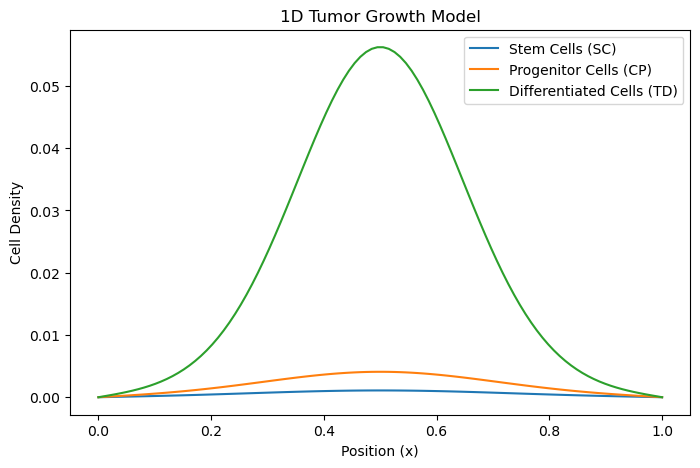

In [107]:
# Plot results
plt.figure(figsize=(8, 5))
plt.plot(x, C1, label='Stem Cells (SC)')
plt.plot(x, C2, label='Progenitor Cells (CP)')
plt.plot(x, C3, label='Differentiated Cells (TD)')
plt.xlabel('Position (x)')
plt.ylabel('Cell Density')
plt.title('1D Tumor Growth Model')
plt.legend()
plt.show()

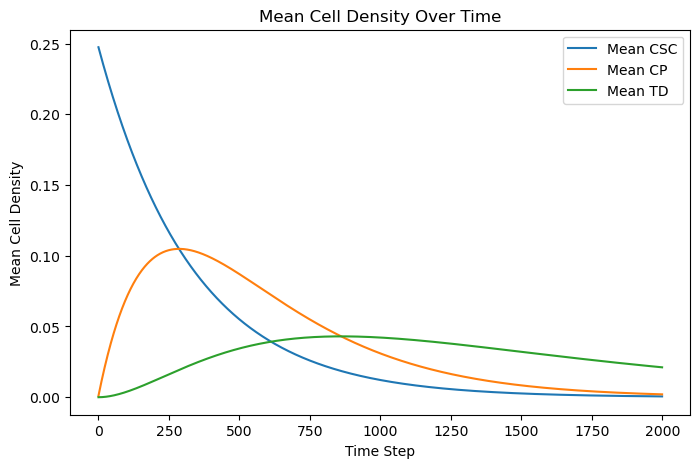

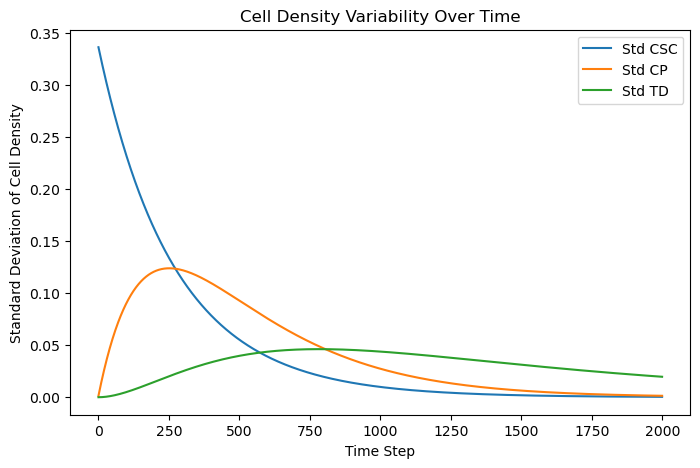

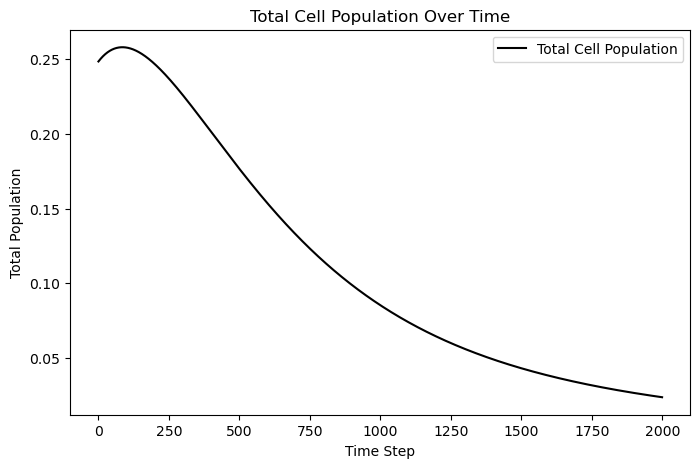

In [108]:
# Plot statistics over time
plt.figure(figsize=(8, 5))
plt.plot(range(Nt), mean_C1, label='Mean CSC')
plt.plot(range(Nt), mean_C2, label='Mean CP')
plt.plot(range(Nt), mean_C3, label='Mean TD')
plt.xlabel('Time Step')
plt.ylabel('Mean Cell Density')
plt.title('Mean Cell Density Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(Nt), std_C1, label='Std CSC')
plt.plot(range(Nt), std_C2, label='Std CP')
plt.plot(range(Nt), std_C3, label='Std TD')
plt.xlabel('Time Step')
plt.ylabel('Standard Deviation of Cell Density')
plt.title('Cell Density Variability Over Time')
plt.legend()
plt.show()

# Plot total population over time
plt.figure(figsize=(8, 5))
plt.plot(range(Nt), cell_mass, label='Total Cell Population', color='black')
plt.xlabel('Time Step')
plt.ylabel('Total Population')
plt.title('Total Cell Population Over Time')
plt.legend()
plt.show()


This is a model in which the cells are allowed to grow and interact with each other, but there is no drug diffusion, or limitations on the growth of the cells. In other words this is a system that is considered to have unlimited nutrient supply. To move past this we can introduce a nutrient field, which allows us the model the effect of a limited nutrient supply. This nutrient field will be a function of the position in the domain, and will be a function of time, and will used to limit the growth of the cells. Until a local concentration of the nutrient is reached the cells cannot grow.

We can model this by introducing a nutrient field $N(x,t)$ which will be a function of the position in the domain, and will be a function of time. This equation will be defined as:

$$ \frac{\partial N}{\partial t} = D_N \frac{\partial^2 N}{\partial x^2} - \alpha_1 N C_1 - \alpha_2 N C_2 - \alpha_3 N C_3 $$

Where $D_N$ is the diffusion coefficient of the nutrient, and $\alpha_1, \alpha_2, \alpha_3$ are the consumption rates of the nutrient by the cells.

We can then modify the reaction terms to include the nutrient field. We can first update the renewal rate of the stem cells to be a function of the nutrient concentration.

$$ \lambda_1 = \lambda_1 \frac{N}{N + K_N} $$

Where $K_N$ is the half-saturation constant.

So the reaction term for the stem cells is now given by:

$$ R_1(C_1, C_2, C_3, D, N) = \lambda_1 \frac{N}{N + K_N} C_1 - \mu_1 C_1 - \gamma_1 C_1 $$

